# __Tutorial 3: Meshing in DFN.Lab__

In this tutorial, we will focus on the __meshing__ procedure inside __DFN.Lab__.
<br>
At the end of this tutorial, you will be able to generate __fracture surface meshes__ that are correctly designed and control the number of elements in order to maintain a correct quantity of memory.


## Example 1: Meshing a _DFN_

We first need a _DFN_. If you are not familiar with this part, you can refer to [Tuto2](https://gitlab.com/fractorylab/dfnlab/-/blob/master/Tutorials/Tuto2_Generation_DFN_stochastic.ipynb).
<br>
We will need the __DFNGenerator__ and __DFNBasis__ modules.
<br>
We need the __DFNIO__ module for visualization. 
<br>
For rendering into the Jupyter Notebook, we use [_pyvista_](https://docs.pyvista.org).

In [1]:
%matplotlib inline
import dfnlab.DFNIO as dfn_io
import dfnlab.DFNBasis as dfn
import dfnlab.DFNGenerator as dfn_gen
import os 

In [2]:
display = True

In [3]:
system = dfn.System()
system.buildParallelepiped([0, 0, 0], 30.)
fnet = dfn.DFN(system)

generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(3.,1,100)
generator.setPositionsUniform()
generator.setOrientationsFisher(45,90,15)
generator.setStopDensity(0.25)
generator.generate()
fnet.computeIntersections()

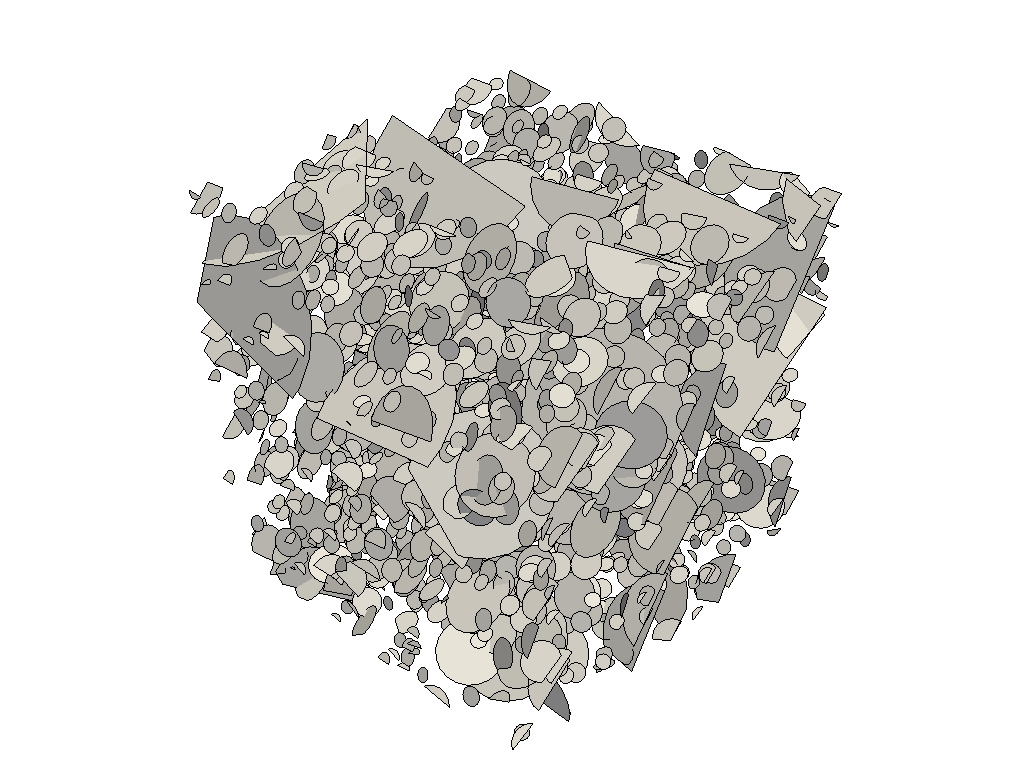

In [4]:
if display :
    import pyvista as pv

    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)

    dfn_io.write_DFN_file(fnet,pathFolder+"/dfn.vtp")
    visu = pv.read(pathFolder+"/dfn.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=True)
    p.show(auto_close=False, use_panel=False)

To generate a mesh, you need to import the __DFNMesh__ module.

In [5]:
import dfnlab.DFNMesh as dfn_mesh

We need to build a _DFNMesh_ object, taking a _DFN_ as argument.

In [6]:
mesh = dfn_mesh.DFNMesh(fnet)  

At the moment, the meshing procedure depends on few parameters controlling the number of elements inside the mesh, and the physics incorporated in the problem. 
<br>
These parameters are described below. A detailed description is also available in the documentation.

#### Set a caracteristical length (recommanded)

The resolution of the mesh is firstly controlled by a caracteristical length. This length is used to control that no edges in the geometry (border or intersection) will be longer than the length.

In [7]:
mesh.setCaracteristicLength(10)  # the default value is 1

#### Resolution on intersections (optional)

Divide the ca

In [8]:
mesh.setResolutionIntersection(2) # Here, edges on intersections will be divided in 2 sub edges
#mesh.setResolutionIntersection(10) # Here, edges on intersections will be divided in 10 sub edges, increasing this number could lead to very memory consuming mesh

#### Resolution on geometry of fractures (optional)

Fracture boundaries are also defined by edges. 
<br>
If a user need to generate more edges on the boundary (without modifying the geometry), then a resolution can be prescribed, as for intersections.

In [9]:
mesh.setResolutionGeometry(2) # each edges on the border of fractures will be devided in 2 sub edges.

#### Set a minimal length for the edges (optional)

This parameter control the minimum size of the edges. However, it is only used for the interior of fractures, the discretization of the geometry (border or intersections) is not dependant on this parameter.

In [10]:
mesh.setMinimumEdgeLength(10) 

#### Set a minimal length for the edges (optional)
This parameter control the maximum size of the edges. Take care, that this parameter is not a priority versus the gradation.

In [11]:
mesh.setMaximumEdgeLength(1) 

#### Set a gradation

In order to minimize the number of cells inside the fractures, users can prescribed a gradation between edges, the gradation coefficient $h$ is used such that:
Let $e_1$ and $e_2$ be two adjacent edges that does not belongs to the geometry, then the size of the edges is controlled such that:
$$ \frac{1}{h} \leq \frac{e_1}{e_2} \leq h $$
[See the MMG documentation for more explanations](https://www.mmgtools.org/mmg-remesher-try-mmg/mmg-remesher-options/mmg-remesher-option-hgrad)

In [12]:
mesh.setGradation(2)  

#### Set physicals features (optional)

It is possible to adress some physical properties to constrain our mesh.
<br>
Giving transmissivities and storage properties is useful if the process lead to null or negative quantities, because unuseful triangles can be removed, and memory can be saved.
<br>
Giving boundary conditions at wells can be useful to constrain the mesh and improve mesh resolution around.
<br>
In order to do this, you need the __DFNHydro__ and __DFNBoundaryCondition__ modules.
<br>
If you are not familiar with these concepts, you can refer to other tutorials.


In [13]:
import dfnlab.DFNBoundaryCondition as dfnBC
import dfnlab.DFNHydro as dfn_hydro

hydro = dfn_hydro.HydraulicProperties(fnet)
hydro.setConstant(1)
storage = dfn_hydro.HydraulicProperties(fnet)
storage.setConstant(1)
dP = 10
bdry = 1 # x-direction
boundaries = dfnBC.DomainBoundaryCondition()
boundaries.setPermeameterCondition(fnet,dP,bdry)


# Setting ot the physical elements
mesh.setBoundaryCondition(boundaries)
mesh.setHydraulicProperties(hydro)
mesh.setStorageProperties(storage)

### Make the generation

Every parameters are set, we generate the mesh with MMG2D from the [MMG platform](https://www.mmgtools.org/) software

In [14]:
mesh.generateMesh()  

347
MMG_creationOfIntersections
Increase intersection size
MMG_computeIntersectionsOnIntersections
parallel research 
Generation of edges 
0 intersections empty
Jarvis 
check the edges are Delaunay - preparation of angles 
check the edges are Delaunay - criteria 1 and 2 
0 intersections empty
2012 Fractures meshed  OK 
0 intersections are deleted not well defined after mesh 


0

### Post process

#### Get quality of the mesh

It is possible to get the histogram of the aspect ratio of the triangles, minimum angles in triangles, maximum angles in triangles, ratio betwwen bigger and smaller edges in triangles

In [15]:
Nbins = 10
AspectRatio = mesh.meshQuality(Nbins) # The Nbins arguments is the number of bins in the histogram.
DistributionAngleMin = mesh.meshQualityAngleMin(Nbins)
DistributionAngleMax = mesh.meshQualityAngleMax(Nbins)
DistributionEdgesRatio = mesh.meshQualityEdgeRatio(Nbins)

Number of triangles: 42086
Averaged quality: 0.801476
Minimum of area: 6.19621e-07
Minimum of perimeter: 0.00513293


Then, we can visualize those quantities

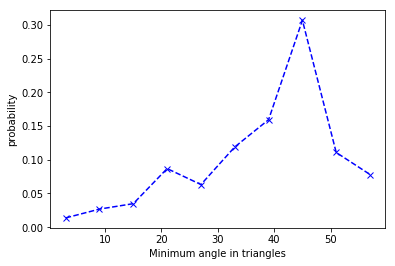

In [16]:
# Minimum angle distribution
import matplotlib.pyplot as plt
import numpy as np 

fig, ax = plt.subplots()
n, bins, patches = ax.hist((DistributionAngleMin), Nbins, density=0,histtype ='step',log=True )
plt.clf()

for i in range(len(DistributionAngleMin)):
    bins[i] = 60*(i+0.5)/(len(DistributionAngleMin))
plt.xlabel('Minimum angle in triangles')
plt.ylabel('probability')
plt.plot(bins[:-1],np.array(DistributionAngleMin[:])/sum(DistributionAngleMin),'x--b')
plt.show();

#### Vizualization of the mesh

It is possible to export the mesh in VTK files for visualization.

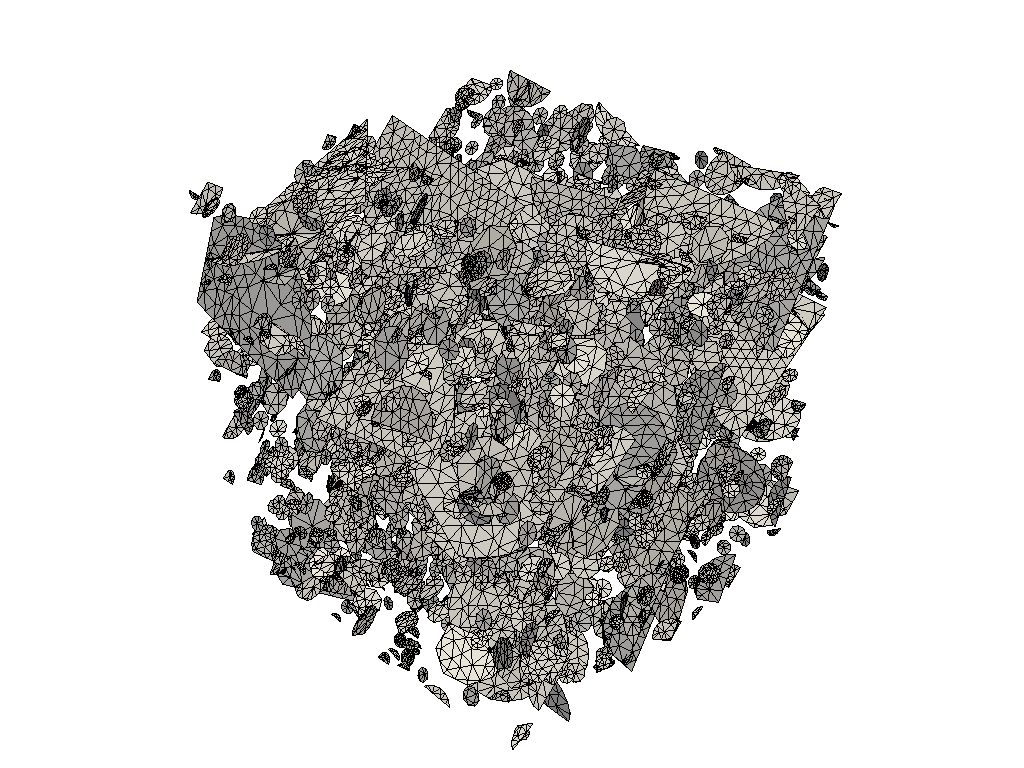

In [17]:
if display:
    Aw = dfn_io.DFNIO_Object(mesh)   # Creation of a specific object, we will discover later how to add more data
    Aw.appendHydroDataOnMesh()   # if hydraulic properties were given, it is possible to dispay them
    Aw.writeVTKOnMesh(pathFolder+"/Mesh_Current.vtp",True)
    
    visu = pv.read(pathFolder+"/Mesh_Current.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu, show_edges=True, color='white')
    p.show(auto_close=False, use_panel=False)

## Summary example

In [18]:
import dfnlab.DFNIO as dfn_io
import dfnlab.DFNBasis as dfn
import dfnlab.DFNGenerator as dfn_gen
import dfnlab.DFNMesh as dfn_mesh
import dfnlab.DFNBoundaryCondition as dfnBC
import dfnlab.DFNHydro as dfn_hydro
import os 

347
MMG_creationOfIntersections
Increase intersection size
MMG_computeIntersectionsOnIntersections
parallel research 
Generation of edges 
0 intersections empty
Jarvis 
check the edges are Delaunay - preparation of angles 
check the edges are Delaunay - criteria 1 and 2 
0 intersections empty
2012 Fractures meshed  OK 
0 intersections are deleted not well defined after mesh 
Number of triangles: 75104
Averaged quality: 0.817545
Minimum of area: 6.23614e-07
Minimum of perimeter: 0.00513293


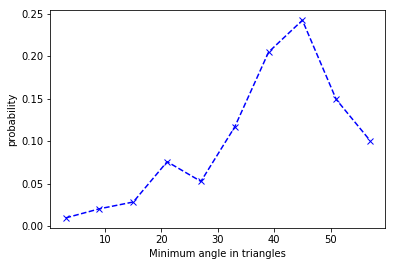

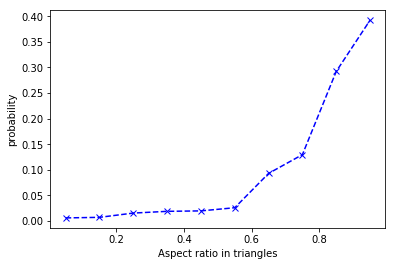

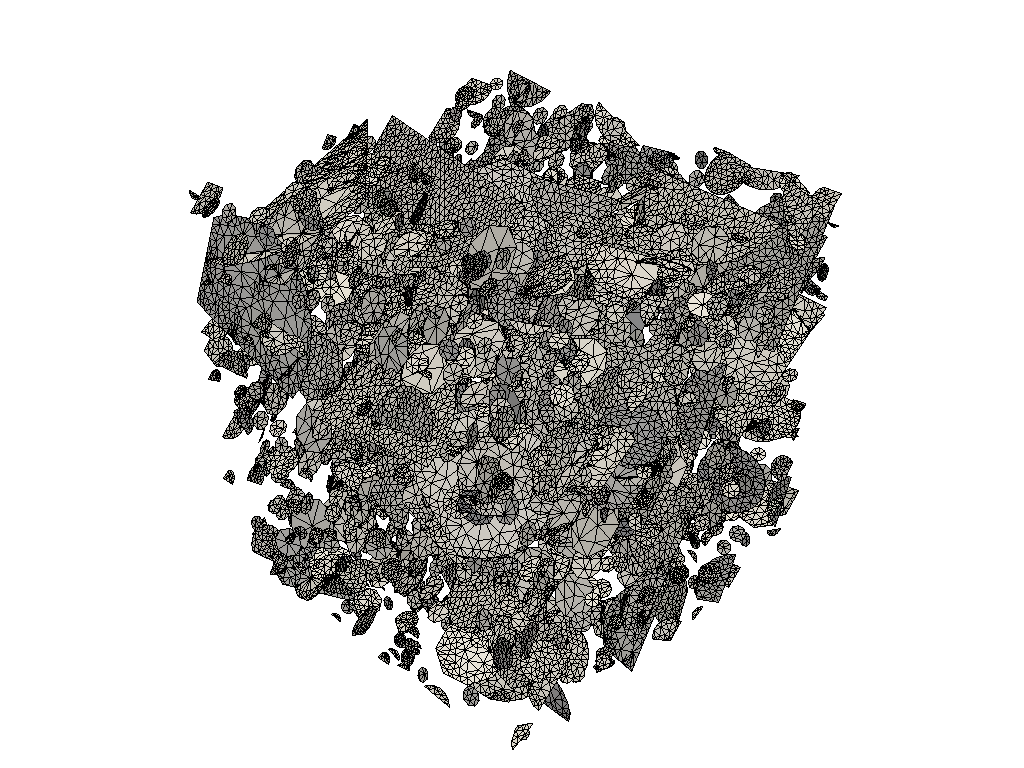

In [19]:
system = dfn.System()
system.buildParallelepiped([0, 0, 0], 30.)
fnet = dfn.DFN(system)


## GENERATION OF THE DFN

generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(3.,1,100)
generator.setPositionsUniform()
generator.setOrientationsFisher(45,90,15)
generator.setStopDensity(0.25)
generator.generate()
fnet.computeIntersections()

## CREATION OF THE MESH

mesh = dfn_mesh.DFNMesh(fnet)  
mesh.setCaracteristicLength(10) 

mesh.setResolutionIntersection(4)
mesh.setResolutionGeometry(2)

mesh.setMinimumEdgeLength(10) 
mesh.setMaximumEdgeLength(0.5) 

mesh.setGradation(1.25)  

# Creation of hydraulic conditions

hydro = dfn_hydro.HydraulicProperties(fnet)
hydro.setConstant(1)
storage = dfn_hydro.HydraulicProperties(fnet)
storage.setConstant(1)
dP = 10
bdry = 1 # x-direction
boundaries = dfnBC.DomainBoundaryCondition()
boundaries.setPermeameterCondition(fnet,dP,bdry)


# Setting ot the physical elements
mesh.setBoundaryCondition(boundaries)
mesh.setHydraulicProperties(hydro)
mesh.setStorageProperties(storage)


mesh.generateMesh()  



# Results

Nbins = 10
AspectRatio = mesh.meshQuality(Nbins) # The Nbins arguments is the number of bins in the histogram.
DistributionAngleMin = mesh.meshQualityAngleMin(Nbins)
DistributionAngleMax = mesh.meshQualityAngleMax(Nbins)
DistributionEdgesRatio = mesh.meshQualityEdgeRatio(Nbins)


import matplotlib.pyplot as plt
import numpy as np 

fig, ax = plt.subplots()
n, bins, patches = ax.hist((DistributionAngleMin), Nbins, density=0,histtype ='step',log=True )
plt.clf()

for i in range(len(DistributionAngleMin)):
    bins[i] = 60*(i+0.5)/(len(DistributionAngleMin))
plt.xlabel('Minimum angle in triangles')
plt.ylabel('probability')
plt.plot(bins[:-1],np.array(DistributionAngleMin[:])/sum(DistributionAngleMin),'x--b')
plt.show();



fig, ax = plt.subplots()
n, bins, patches = ax.hist((AspectRatio), Nbins, density=0,histtype ='step',log=True )
plt.clf()

for i in range(len(AspectRatio)):
    bins[i] = (i+0.5)/(len(AspectRatio)-1)
plt.xlabel('Aspect ratio in triangles')
plt.ylabel('probability')
plt.plot(bins[:-1],np.array(AspectRatio[:-1])/sum(AspectRatio),'x--b')
plt.show();

if display:
    Aw = dfn_io.DFNIO_Object(mesh)   # Creation of a specific object, we will discover later how to add more data
    Aw.appendHydroDataOnMesh()   # if hydraulic properties were given, it is possible to dispay them
    Aw.writeVTKOnMesh(pathFolder+"/Mesh_Current.vtp",True)
    
    visu = pv.read(pathFolder+"/Mesh_Current.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu, show_edges=True, color='white')
    p.show(auto_close=False, use_panel=False)